<a href="https://colab.research.google.com/github/manlio99/Materia-de-aprendizaje/blob/master/8_feature_selection/Empresa2/MercadoLibre_Avanzado_h2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Problema ML</h2>



# Por: Manlio Massiris
    Análisis exploratorio - explorar y analizar el conjunto de datos
    Modelo base - entrenar un modelo base
    Base sin títulos - entrenar un modelo base sin títulos
        ¿cómo de predictivo es nuestro modelo?
        ¿qué variables son importantes?
    Características - añadir nuevas características que creemos que pueden ayudar a mejorar los resultados
        Bag of words
        Categorical columns Target Encoding
        Anomaly Score with Isolation Forest
    Entrenamiento de los modelos con los datos calculados
        ¿cómo de predictivo son nuestros modelos?
        ¿qué variables son importantes?
    Modelo subrogado - construir un modelo de árbol de decisión subrogado para explicar, a alto nivel, cómo predice nuestro modelo
        ¿dónde están los puntos de inflexión?
        ¿cuáles son las recomendaciones para el cliente? 





Tenemos que utilizar java 8, es uno de los requisitos de H2O, por lo cual, la instalamos y despues la indicamos como preferencia en colab.

In [1]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install openjdk-8-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 40 not upgraded.
Need to get 43.5 MB of archives.
After this 

Ahora la preferncia es java 11

In [4]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode)


This command displays Java version.

Make sure it displays openjdk version 1.8.*

If it displays otherwise, (such as openjdk version 10.*) H2O might display an error like this:

<i>H2OServerError: Server process terminated with error code 1</i>

To fix the issue, try this command to change Java version.

```!update-alternatives --config java```

In [5]:
!sudo update-alternatives --set java /usr/lib/jvm/jdk1.8.0_version/bin/java
#!update-alternatives --config java

update-alternatives: error: alternative /usr/lib/jvm/jdk1.8.0_version/bin/java for java not registered; not setting


In [6]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode)


Tambien usa una version vieja de pandas.

In [7]:
!pip install pandas==0.19.2

     |████████████████████████████████| 9.2 MB 5.5 MB/s 
  ERROR: Failed building wheel for pandas
  Running setup.py clean for pandas
Failed to build pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
    Running setup.py install for pandas ... error
  Rolling back uninstall of pandas
  Moving to /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~andas-1.1.5.dist-info
  Moving to /usr/local/lib/python3.7/dist-packages/pandas/
   from /usr/local/lib/python3.7/dist-packages/~andas
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-kgh73rcm/pandas_89580145bd6c4530b9e84c9cb67fbda7/setup.py'"'"'; __file__='"'"'/tmp/pip-install-kgh73rcm/pandas_89580145bd6c4530b9e84c9cb67fbda7/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', op

In [8]:
# Instalamos h2o
!pip install H2O

     |████████████████████████████████| 170.0 MB 28 kB/s 
  Created wheel for H2O: filename=h2o-3.32.1.7-py2.py3-none-any.whl size=170040343 sha256=82f39488ba7c0294ed3a477f1da42ac2d3e1a312fcfc638558707de4b505cc39
  Stored in directory: /root/.cache/pip/wheels/6e/60/8f/172971bebc94f839b69460f46c9a5fc9e7e88457453bb149d7
Successfully built H2O


Iniciamos el servidor.
Prestar atencion a la cantidad de memoria usada, pues se puede modificar.

In [9]:
import h2o
h2o.init()
#memoria limitada a 2gb y 1 hr de entrenamiento

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppasi03xm
  JVM stdout: /tmp/tmppasi03xm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppasi03xm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,"7 days, 6 hours and 15 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_m9darp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


### Task 2:  Pre-Procesamiento de la Data
Importing Packages

In [10]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
import ast

In [11]:
VENTAS_ = gc.open("VENTAS").get_worksheet(0)
ventas = pd.DataFrame.from_dict(VENTAS_.get_all_records())
# reemplazamos los NA por 0 para los productos que no tienen VAR_ID
ventas.ITE_VAR_ID.fillna(0, inplace=True)
ventas["ITE_VAR_ID"] = ventas["ITE_VAR_ID"].str.replace('NA','0').str.replace(',','').astype('int')
# ventas.isnull().any() # Looking for missing values
# ventas.columns # column names
ventas['Formatted_Date'] = pd.to_datetime(ventas['DATE'])


In [12]:
stock_ = gc.open("STOCK").get_worksheet(0)
stock = pd.DataFrame.from_dict(stock_.get_all_records())

stock.STOCK.fillna(0, inplace=True)
stock["ITE_VAR_ID"][stock["ITE_VAR_ID"]==""] = 0
stock['Formatted_Date'] = pd.to_datetime(stock['DATE'])
stock["STOCK"] = [float(str(i).replace("NA", "NaN")) for i in stock["STOCK"]]
stock

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,DATE,SITIO,NEGOCIO_ID,ITE_ITEM_ID,ITE_VAR_ID,STOCK,Formatted_Date
0,5/7/2020,MLA,960899288,1723342196,115650105316,1857.0,2020-05-07
1,5/7/2020,MLA,960899288,1708370636,0,0.0,2020-05-07
2,21/7/2020,MLA,960899288,1698330614,107860378264,0.0,2020-07-21
3,5/3/2020,MLA,960899288,1665695740,97319558766,0.0,2020-05-03
4,6/6/2020,MLA,960899288,1665695740,97319558766,0.0,2020-06-06
...,...,...,...,...,...,...,...
14405,22/6/2020,MLA,960899288,1669368892,98501017586,0.0,2020-06-22
14406,28/6/2020,MLA,960899288,1712991908,112540051638,0.0,2020-06-28
14407,20/5/2020,MLA,960899288,1677571040,101109339672,0.0,2020-05-20
14408,16/3/2020,MLA,960899288,1654750946,94010265796,0.0,2020-03-16


In [13]:
VISITAS_ = gc.open("VISITAS").get_worksheet(0)
visitas = pd.DataFrame.from_dict(VISITAS_.get_all_records())
visitas['DEVICE'] = visitas['DEVICE'].astype('category')# encoding
visitas['DEVICE_cat'] = visitas['DEVICE'].cat.codes
visitas['Formatted_Date'] = pd.to_datetime(visitas['DATE'])


In [14]:
PUBLICACIONES_ = gc.open("PUBLICACIONES").get_worksheet(0)
publi = pd.DataFrame.from_dict(PUBLICACIONES_.get_all_records())
publi['ITE_ATT_BRAND'] = publi['ITE_ATT_BRAND'].astype('category') # encoding
publi['ITE_ATT_BRAND_Cat'] = publi['ITE_ATT_BRAND'].cat.codes
publi['ITE_DOM_DOMAIN_ID'] = publi['ITE_DOM_DOMAIN_ID'].astype('category') # encoding
publi['ITE_DOM_DOMAIN_ID_Cat'] = publi['ITE_DOM_DOMAIN_ID'].cat.codes


# print(publi)
# publi.columns # column names
# publi.head(10) # first 10 records
# publi.describe() # summary
publi

,SITIO,ITE_ITEM_ID,ITE_ITEM_TITLE,NEGOCIO_ID,ITE_STATUS,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat
0,MLA,1728401696,Acondicionador Swing Liso Perfecto X 200 Ml,1074090314,paused,,Botella,40,0
1,MLA,1721904356,Loción Fresh Hidratante x 400 Ml,1074090314,paused,,FARMACITY,114,0
2,MLA,1719911868,Crema Dental Colgate Total Salud Visible 100ml,1074090314,active,MLA-TOOTHPASTES,Colgate,81,108
3,MLA,1701286858,Samsung Libre Galaxy S10 No 128 Gb 8 Gb,960899288,closed,,Samsung,316,0
4,MLA,1707820872,Samsung Libre Galaxy S10 No 128 Gb 8 Gb,960899288,closed,,Samsung,316,0
...,...,...,...,...,...,...,...,...,...
2769,MLA,1741660796,Pañuelos Descartables Elite Compacto X8 C/ext....,1074090314,paused,MLA-FACIAL_TISSUES,Elite,109,34
2770,MLA,1721903042,Protectores Mamarios Anatómicos Farmacity Bebé...,1074090314,paused,,FARMACITY BEBE,115,0
2771,MLA,1704503784,Nosotras Invisible Clasica C/alas Bol.x 16 Utoa,1074090314,active,MLA-PADS,NOSOTRAS INVISIBLE CLASICA,208,70
2772,MLA,1704505398,Colgate Herbal Blanqueadora C/calc.y Fluor 90 ...,1074090314,closed,,Colgate,81,0


# Vamos a aplicar bag of words para los títulos de la publicación

primero traducimos todos los títulos al inglés y guardamos los resultados porque demora mucho.

In [15]:
# !pip install googletrans==4.0.0-rc1
# from googletrans import Translator
# translator = Translator()
# print(translator.translate("Acondicionador Swing Liso Perfecto X 200 Ml", src='es', dest='en'))

# publi['ITE_ITEM_TITLE_En'] = publi['ITE_ITEM_TITLE'].apply(translator.translate, src='es', dest='en').apply(getattr, args=('text',))
# publi.to_csv("/content/drive/MyDrive/Colab Notebooks/MercadoLib/publi2.csv")

In [16]:
publi2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MercadoLib/publi2.csv")
# publi2["ITE_ITEM_TITLE_En"] = publi2["ITE_ITEM_TITLE_En"]
publi2

,Unnamed: 0,SITIO,ITE_ITEM_ID,ITE_ITEM_TITLE,NEGOCIO_ID,ITE_STATUS,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En
0,0,MLA,1728401696,Acondicionador Swing Liso Perfecto X 200 Ml,1074090314,paused,NaN,Botella,40,0,Perfect smooth swing conditioner x 200 ml
1,1,MLA,1721904356,Loción Fresh Hidratante x 400 Ml,1074090314,paused,NaN,FARMACITY,114,0,Fresh moisturizing lotion x 400 ml
2,2,MLA,1719911868,Crema Dental Colgate Total Salud Visible 100ml,1074090314,active,MLA-TOOTHPASTES,Colgate,81,108,Dental cream Colgate Total Health visible 100ml
3,3,MLA,1701286858,Samsung Libre Galaxy S10 No 128 Gb 8 Gb,960899288,closed,NaN,Samsung,316,0,Samsung Free Galaxy S10 No 128 GB 8 GB
4,4,MLA,1707820872,Samsung Libre Galaxy S10 No 128 Gb 8 Gb,960899288,closed,NaN,Samsung,316,0,Samsung Free Galaxy S10 No 128 GB 8 GB
...,...,...,...,...,...,...,...,...,...,...,...
2769,2769,MLA,1741660796,Pañuelos Descartables Elite Compacto X8 C/ext....,1074090314,paused,MLA-FACIAL_TISSUES,Elite,109,34,Discardable Scarves Compact Elite X8 C / EXT.S...
2770,2770,MLA,1721903042,Protectores Mamarios Anatómicos Farmacity Bebé...,1074090314,paused,NaN,FARMACITY BEBE,115,0,Anatomical Breast Protectors Farmcity Baby X 24 A
2771,2771,MLA,1704503784,Nosotras Invisible Clasica C/alas Bol.x 16 Utoa,1074090314,active,MLA-PADS,NOSOTRAS INVISIBLE CLASICA,208,70,We invisible Classica C / Alas Bol.x 16 UtoA
2772,2772,MLA,1704505398,Colgate Herbal Blanqueadora C/calc.y Fluor 90 ...,1074090314,closed,NaN,Colgate,81,0,Colgate Herbal Whitening C / Calc.And Fluor 90...


# Unimos todos los datos por "ITE_ITEM_ID" y "NEGOCIO_ID"

In [17]:
df = pd.merge(ventas, stock,  how='inner', on=["Formatted_Date", "ITE_ITEM_ID","ITE_VAR_ID","NEGOCIO_ID","SITIO","DATE"])
df = pd.merge(df, visitas,  how='inner', on=["Formatted_Date", "ITE_ITEM_ID","NEGOCIO_ID","DATE"])
df = pd.merge(df, publi2,  how='inner', on=["ITE_ITEM_ID","NEGOCIO_ID"])
# df.drop(columns=["SITIO_y","SITIO_x"])
df.drop(columns=["SITIO_y","SITIO_x","SITIO"])


,DATE,ITE_ITEM_ID,ITE_VAR_ID,NEGOCIO_ID,NEGOCIO,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,Unnamed: 0,ITE_ITEM_TITLE,ITE_STATUS,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En
0,11/11/2019,1642811552,90783591526,960899288,ELECTRONICS,34,2019-11-11,107.0,android,2935,2,95,Celular Samsung M10 16gb 2gb Ram Liberado,paused,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released
1,11/11/2019,1642811552,90783591526,960899288,ELECTRONICS,34,2019-11-11,107.0,android,2935,2,769,Samsung Galaxy M10 - Negro Carbón - 16 Gb - 2 Gb,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
2,11/11/2019,1642811552,90783591526,960899288,ELECTRONICS,34,2019-11-11,107.0,android,2935,2,930,Samsung Galaxy M10 16 Gb Azul Océano 2 Gb Ram,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM
3,11/11/2019,1642811552,90783591526,960899288,ELECTRONICS,34,2019-11-11,107.0,Mobile-WEB,1233,0,95,Celular Samsung M10 16gb 2gb Ram Liberado,paused,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released
4,11/11/2019,1642811552,90783591526,960899288,ELECTRONICS,34,2019-11-11,107.0,Mobile-WEB,1233,0,769,Samsung Galaxy M10 - Negro Carbón - 16 Gb - 2 Gb,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385,7/7/2020,1723342196,115650105316,960899288,ELECTRONICS,6,2020-07-07,1846.0,Mobile-WEB,12,0,150,Afeitadora Philips Wet & Dry S3122/51,active,MLA-HAIR_CLIPPERS,Philips,261,40,Shaving Philips Wet & Dry S3122 / 51
4386,7/7/2020,1730257502,117885068044,960899288,ELECTRONICS,5,2020-07-07,192.0,Std_Desktop,93,1,506,Samsung Galaxy S20 Plus Negro + Galaxy Buds Plus,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus
4387,7/7/2020,1730257502,117885068044,960899288,ELECTRONICS,5,2020-07-07,192.0,Mobile-WEB,78,0,506,Samsung Galaxy S20 Plus Negro + Galaxy Buds Plus,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus
4388,7/7/2020,1730257502,117885068044,960899288,ELECTRONICS,5,2020-07-07,192.0,android,212,2,506,Samsung Galaxy S20 Plus Negro + Galaxy Buds Plus,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus


In [145]:
df.sort_values(by=['VENTAS'])

,DATE,SITIO_x,ITE_ITEM_ID,ITE_VAR_ID,NEGOCIO_ID,NEGOCIO,VENTAS,Formatted_Date,STOCK,SITIO_y,DEVICE,QTY_VISITS,DEVICE_cat,Unnamed: 0,SITIO,ITE_ITEM_TITLE,ITE_STATUS,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En
937,12/11/2019,MLA,1642699308,90554654474,960899288,ELECTRONICS,1,2019-12-11,0.0,MLA,ios,1,3,2490,MLA,Celular Motorola Moto G6 Xt-1925 3gb 32gb Cuotas Sin Interes,paused,MLA-CELLPHONES,Motorola,203,16,Motorola Moto G6 XT-1925 3GB 32GB Fees without interest
1046,5/3/2020,MLA,1654754638,94011314006,960899288,ELECTRONICS,1,2020-05-03,0.0,MLA,android,1,2,31,MLA,Motorola Moto G6 Plus 64gb 4gb Ram Cuotas Sin Interes,paused,MLA-CELLPHONES,Motorola,203,16,Motorola Moto G6 Plus 64GB 4GB RAM Fees without interest
3892,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,Mobile-WEB,2,0,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
3893,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,android,23,2,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
3894,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,ios,10,3,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,4/4/2020,MLA,1642811552,90783591526,960899288,ELECTRONICS,345,2020-04-04,0.0,MLA,ios,1137,3,769,MLA,Samsung Galaxy M10 - Negro Carbón - 16 Gb - 2 Gb,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
3606,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,ios,287,3,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle
3605,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,Mobile-WEB,373,0,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle
3604,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,Std_Desktop,494,1,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle


Todo resumido

In [18]:
# df2 = df.drop(["SITIO","SITIO_y","SITIO_x","NEGOCIO_ID","NEGOCIO","DATE", "ITE_STATUS", "Unnamed: 0", "ITE_ITEM_TITLE"], axis=1)
# df2.to_csv("/content/drive/MyDrive/Colab Notebooks/MercadoLib/df2.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MercadoLib/df2.csv", index_col=[0])


df2 

,ITE_ITEM_ID,ITE_VAR_ID,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En
0,1642811552,90783591526,34,2019-11-11,107.0,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released
1,1642811552,90783591526,34,2019-11-11,107.0,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
2,1642811552,90783591526,34,2019-11-11,107.0,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM
3,1642811552,90783591526,34,2019-11-11,107.0,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released
4,1642811552,90783591526,34,2019-11-11,107.0,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385,1723342196,115650105316,6,2020-07-07,1846.0,Mobile-WEB,12,0,MLA-HAIR_CLIPPERS,Philips,261,40,Shaving Philips Wet & Dry S3122 / 51
4386,1730257502,117885068044,5,2020-07-07,192.0,Std_Desktop,93,1,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus
4387,1730257502,117885068044,5,2020-07-07,192.0,Mobile-WEB,78,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus
4388,1730257502,117885068044,5,2020-07-07,192.0,android,212,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy S20 Plus Black + Galaxy Buds Plus


In [19]:
df2["ITE_VAR_ID"] = df2["ITE_VAR_ID"].astype('category')
df2["ITE_ITEM_ID"] = df2["ITE_ITEM_ID"].astype('category')
df2["DEVICE_cat"] = df2["DEVICE_cat"].astype('category')
# df2["ITE_ITEM_TITLE"] = df2["ITE_ITEM_TITLE"].astype(str)
df2["ITE_ATT_BRAND_Cat"] = df2["ITE_ATT_BRAND_Cat"].astype('category')
df2["ITE_DOM_DOMAIN_ID_Cat"] = df2["ITE_DOM_DOMAIN_ID_Cat"].astype('category')

df2.dtypes

ITE_ITEM_ID              category
ITE_VAR_ID               category
VENTAS                      int64
Formatted_Date             object
STOCK                     float64
DEVICE                     object
QTY_VISITS                  int64
DEVICE_cat               category
ITE_DOM_DOMAIN_ID          object
ITE_ATT_BRAND              object
ITE_ATT_BRAND_Cat        category
ITE_DOM_DOMAIN_ID_Cat    category
ITE_ITEM_TITLE_En          object
dtype: object

iniciamos H2o y Entrenamos un modelo base

In [20]:
h2o_df = h2o.H2OFrame(df2)
h2o_df[["ITE_ITEM_ID","ITE_VAR_ID","DEVICE_cat"]].asfactor()
h2o_df["year"] = h2o_df["Formatted_Date"].year()
h2o_df["month"] = h2o_df["Formatted_Date"].month()
h2o_df["day"] = h2o_df["Formatted_Date"].day()
h2o_df.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:4390
Cols:16




,ITE_ITEM_ID,ITE_VAR_ID,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day
type,int,int,int,time,int,enum,int,int,enum,enum,int,int,enum,int,int,int
mins,1642699308.0,0.0,1.0,1573430400000.0,-1.0,,0.0,0.0,,,172.0,2.0,,2019.0,1.0,1.0
mean,1667034283.5394104,96598112803.01068,23.391116173120757,1583643234259.6812,137.83750000000026,,397.93052391799574,1.4123006833712972,,,282.2164009111616,17.88701594533028,,2019.9589977220937,3.5849658314350736,4.726195899772198
maxs,1730257502.0,117885068044.0,1040.0,1594080000000.0,2271.0,,47167.0,3.0,,,316.0,102.0,,2020.0,12.0,12.0
sigma,20838505.780605163,13519393462.46567,46.52179965497424,4937633148.451354,326.6519485134248,,1995.3457227152057,1.068803655419777,,,52.60356214473914,11.319466271873555,,0.1983180529355696,2.4014789883965033,2.323706051443902
zeros,0,65,0,0,2468,,28,1129,,,0,0,,0,0,0
missing,0,0,0,0,390,0,0,0,0,0,0,0,0,0,0,0
0,1642811552.0,90783591526.0,34.0,2019-11-11 00:00:00,107.0,android,2935.0,2.0,MLA-CELLPHONES,Samsung,316.0,16.0,Samsung cell phone M10 16GB 2GB RAM released,2019.0,11.0,11.0
1,1642811552.0,90783591526.0,34.0,2019-11-11 00:00:00,107.0,android,2935.0,2.0,MLA-CELLPHONES,Samsung,316.0,16.0,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019.0,11.0,11.0
2,1642811552.0,90783591526.0,34.0,2019-11-11 00:00:00,107.0,android,2935.0,2.0,MLA-CELLPHONES,Samsung,316.0,16.0,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019.0,11.0,11.0


In [21]:
import datetime
train = h2o_df[h2o_df['Formatted_Date'] < datetime.datetime(2020, 5, 9, 0, 0, 0),:]
test = h2o_df[h2o_df['Formatted_Date'] >= datetime.datetime(2020, 5, 9, 0, 0, 0),:]
train.shape
test.shape

(564, 16)

In [22]:
x = train.columns
y = "VENTAS"
x.remove(y)
from h2o.estimators import H2OGradientBoostingEstimator
gbm_baseline = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_baseline.hex", 
                                                   ntrees = 500, 
                                                  #  stopping_rounds = 10, score_tree_interval = 5, # early stopping 
                                                   nfolds = 5, # 5-fold cross validation
                                                   balance_classes=False,
                                                  )
gbm_baseline.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
print("rmse on - Baseline: " + str(round(gbm_baseline.rmse(xval = True), 4)))

rmse on - Baseline: 11.5954


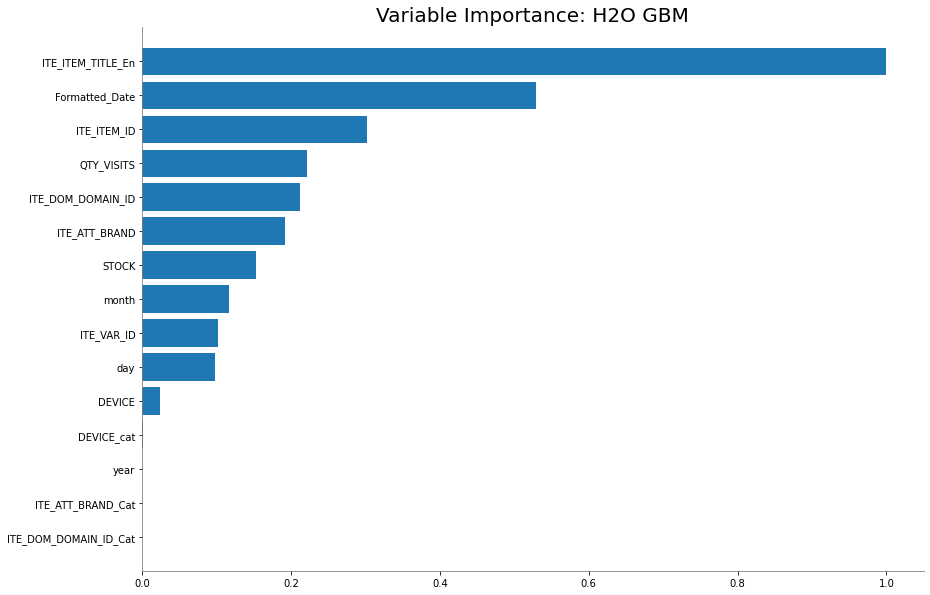

In [24]:
gbm_baseline.varimp_plot(num_of_features=20)

Como ITE_ITEM_TITLE_En es la variable mas importante en nuestro modelo, probemos a ver que pasa si no la tenemos encuenta.

In [25]:
x = train.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
from h2o.estimators import H2OGradientBoostingEstimator
gbm_no_title = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_no_title.hex", 
                                                   ntrees = 500, 
                                                  #  stopping_rounds = 10, score_tree_interval = 5, # early stopping 
                                                   nfolds = 5, # 5-fold cross validation
                                                   balance_classes=False,
                                                  )
gbm_no_title.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


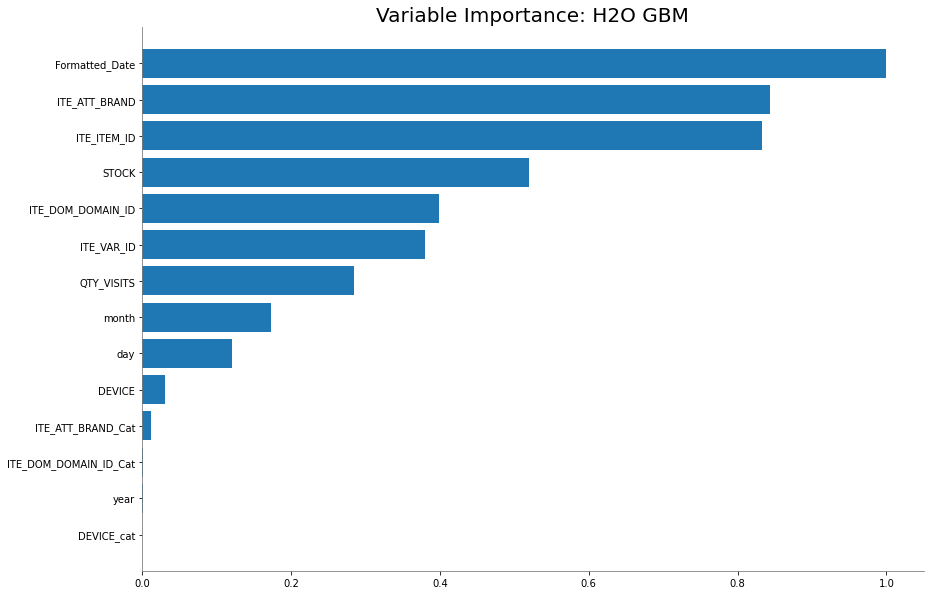

In [26]:
gbm_no_title.varimp_plot(num_of_features=20)

In [27]:
print("rmse on - Baseline: " + str(round(gbm_baseline.rmse(xval = True), 4)))
print("rmse on - No title: " + str(round(gbm_no_title.rmse(xval = True), 4)))

rmse on - Baseline: 11.5954
rmse on - No title: 12.2915


# Ahora intentamos title encoder

In [28]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
STOP_WORDS[0:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

In [129]:
def tokenize(sentences, stop_words = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    # tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:] SI quiero numeros
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(stop_words)),:]
    return tokenized_words

In [30]:
# Break name into sequence of words
name = tokenize(h2o_df["ITE_ITEM_TITLE_En"].ascharacter())

Entrenamos

In [31]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 20, model_id = "w2v.hex")
w2v_model.train(training_frame=name)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


Comprobamos coherencia - sinónimos para la palabra "Phone"

In [32]:

w2v_model.find_synonyms("phone", count = 5)

OrderedDict([('thinq', 0.7899001836776733),
             ('cell', 0.7494138479232788),
             ('platinum', 0.6863532662391663),
             ('lg', 0.6753284335136414),
             ('interest', 0.6629090309143066)])

Hay múltiples palabras para cada título, por lo que tendremos que agregar nuestras word embeddings para que haya un único vector de palabras por cada día de venta. 


In [33]:
# Calculate a vector for each name
train_name_vecs = w2v_model.transform(name, aggregate_method = "AVERAGE")
train_name_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333


Lo unimos con el dataset original

In [34]:
ext_h2o_df = h2o_df.cbind(train_name_vecs)
ext_h2o_df

ITE_ITEM_ID,ITE_VAR_ID,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Std_Desktop,721,1,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333


Dividiremos los datos en entrenamiento y prueba por tiempo.  Nuestros datos de prueba consistirán en los últimos tres meses de datos.

In [35]:
# ext_h2o_df["year"] =ext_h2o_df["Formatted_Date"].year()
# ext_h2o_df["month"] =ext_h2o_df["Formatted_Date"].month()
# ext_h2o_df["day"] =ext_h2o_df["Formatted_Date"].day()

In [36]:
import datetime
train = ext_h2o_df[ext_h2o_df['Formatted_Date'] < datetime.datetime(2020, 5, 9, 0, 0, 0),:]
test = ext_h2o_df[ext_h2o_df['Formatted_Date'] >= datetime.datetime(2020, 5, 9, 0, 0, 0),:]
train.shape
test.shape

(564, 36)

In [37]:
x = train.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
from h2o.estimators import H2OGradientBoostingEstimator
gbm_word_embeddings = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_word-embeddings.hex", 
                                                   ntrees = 500, 
                                                  #  stopping_rounds = 10, score_tree_interval = 5, # early stopping 
                                                   nfolds = 5, # 5-fold cross validation
                                                   balance_classes=False,
                                                  )
gbm_word_embeddings.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [38]:
print("rmse on - Baseline: " + str(round(gbm_baseline.rmse(xval = True), 4)))
print("rmse on - No Desc: " + str(round(gbm_no_title.rmse(xval = True), 4)))
print("rmse on - Word Embeddings: " + str(round(gbm_word_embeddings.rmse(xval = True), 4)))

rmse on - Baseline: 11.5954
rmse on - No Desc: 12.2915
rmse on - Word Embeddings: 11.3298


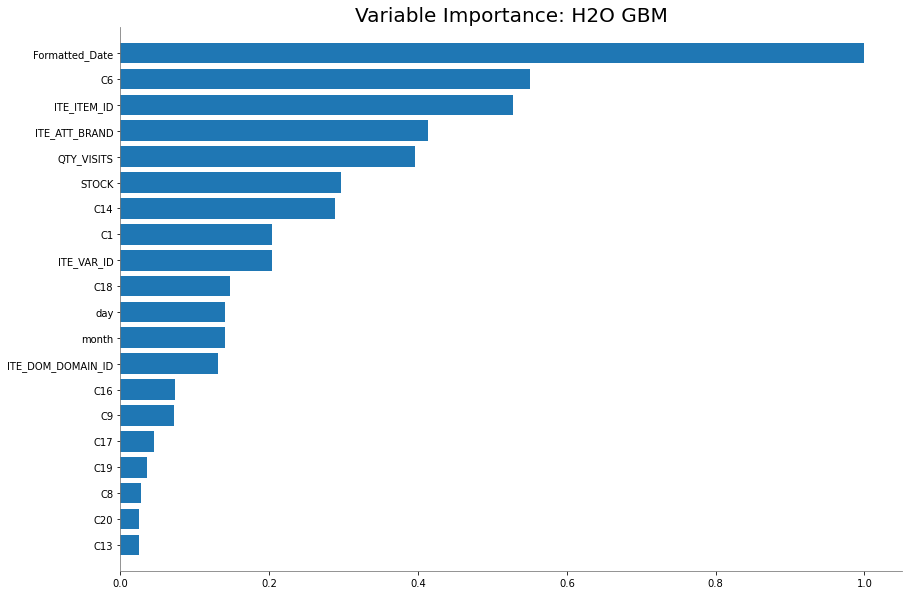

In [39]:
gbm_word_embeddings.varimp_plot(num_of_features=20)

# Target Encoding on large Categorical columns
Era esperado que la fecha tuviera gran importancia por la estacionalidad de las ventas. 

Además, "ITE_ITEM_ID", "ITE_VAR_ID", "ITE_ATT_BRAND" & "ITE_DOM_DOMAIN_ID" tienen gran importancia, por lo cual haremos un Target Encoding, pues estas variables tienen el mismo valor para cada item.

In [40]:
train = ext_h2o_df[ext_h2o_df['Formatted_Date'] < datetime.datetime(2020, 5, 9, 0, 0, 0),:]
test = ext_h2o_df[ext_h2o_df['Formatted_Date'] >= datetime.datetime(2020, 5, 9, 0, 0, 0),:]
train.shape
test.shape
test

ITE_ITEM_ID,ITE_VAR_ID,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Std_Desktop,14,1,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Std_Desktop,14,1,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Std_Desktop,14,1,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,android,83,2,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,android,83,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,android,83,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Mobile-WEB,13,0,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Mobile-WEB,13,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,Mobile-WEB,13,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,2,2020-06-02 00:00:00,0,ios,4,3,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333


In [118]:
from h2o.estimators import H2OTargetEncoderEstimator
response='VENTAS'

# Choose which columns to encode
encoded_columns = ["ITE_ITEM_ID", "ITE_VAR_ID", "ITE_ATT_BRAND", "ITE_DOM_DOMAIN_ID"]

# For k_fold strategy we need to provide fold column
fold_column = "kfold_column"
train[fold_column] = train.kfold_column(n_folds=5, seed=1234)

# Train a TE model
titanic_te = H2OTargetEncoderEstimator(fold_column=fold_column,
                                       data_leakage_handling="k_fold",
                                       blending=True,
                                       inflection_point=3,
                                       smoothing=10,
                                       noise=0.15,     # In general, the less data you have the more regularization you need
                                       seed=1234)
titanic_te.train(x=encoded_columns,
                 y=response,
                 training_frame=train)

# New target encoded train and test sets
train_te = titanic_te.transform(frame=train, as_training=True)
test_te = titanic_te.transform(frame=test, noise=0)


targetencoder Model Build progress: |█████████████████████████████████████| 100%


resultado del categorical encoder

In [119]:
train_te

ITE_ITEM_ID,ITE_VAR_ID,ITE_DOM_DOMAIN_ID_te,ITE_ATT_BRAND_te,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,AnomalyScore,AnomalyScore0,kfold_column,VENTAS
1.64281e+09,9.07836e+10,22.6286,25.8844,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,android,2935,2,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,0.22963,0.22963,2,34
1.64281e+09,9.07836e+10,22.4236,25.8012,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,android,2935,2,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,0.296296,0.296296,0,34
1.64281e+09,9.07836e+10,22.5317,25.9093,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,android,2935,2,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,0.22963,0.22963,0,34
1.64281e+09,9.07836e+10,22.4217,25.7146,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,0.22963,0.22963,1,34
1.64281e+09,9.07836e+10,22.4961,25.7816,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,0.244444,0.244444,3,34
1.64281e+09,9.07836e+10,22.5899,25.8753,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,0.214815,0.214815,3,34
1.64281e+09,9.07836e+10,22.4008,25.4933,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,ios,74,3,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,0.192593,0.192593,4,34
1.64281e+09,9.07836e+10,22.4546,25.8323,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,ios,74,3,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,0.244444,0.244444,0,34
1.64281e+09,9.07836e+10,22.5391,25.8245,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,ios,74,3,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,0.2,0.2,3,34
1.64281e+09,9.07836e+10,22.4022,25.6951,MLA-CELLPHONES,Samsung,2019-11-11 00:00:00,107,Std_Desktop,721,1,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-

In [43]:
train_te[["ITE_ITEM_ID", "ITE_VAR_ID", "ITE_ATT_BRAND", "ITE_ATT_BRAND_te", "ITE_DOM_DOMAIN_ID", "ITE_DOM_DOMAIN_ID_te"]]

ITE_ITEM_ID,ITE_VAR_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_te,ITE_DOM_DOMAIN_ID,ITE_DOM_DOMAIN_ID_te
1.64281e+09,9.07836e+10,Samsung,25.8844,MLA-CELLPHONES,22.6286
1.64281e+09,9.07836e+10,Samsung,25.8012,MLA-CELLPHONES,22.4236
1.64281e+09,9.07836e+10,Samsung,25.9093,MLA-CELLPHONES,22.5317
1.64281e+09,9.07836e+10,Samsung,25.7146,MLA-CELLPHONES,22.4217
1.64281e+09,9.07836e+10,Samsung,25.7816,MLA-CELLPHONES,22.4961
1.64281e+09,9.07836e+10,Samsung,25.8753,MLA-CELLPHONES,22.5899
1.64281e+09,9.07836e+10,Samsung,25.4933,MLA-CELLPHONES,22.4008
1.64281e+09,9.07836e+10,Samsung,25.8323,MLA-CELLPHONES,22.4546
1.64281e+09,9.07836e+10,Samsung,25.8245,MLA-CELLPHONES,22.5391
1.64281e+09,9.07836e+10,Samsung,25.6951,MLA-CELLPHONES,22.4022


In [44]:
x = train_te.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
# x.remove("ITE_ITEM_ID")
# x.remove("ITE_VAR_ID")
x.remove("ITE_ATT_BRAND")
x.remove("ITE_DOM_DOMAIN_ID")
x.remove("ITE_ATT_BRAND_Cat")
x.remove("ITE_DOM_DOMAIN_ID_Cat")


from h2o.estimators import H2OGradientBoostingEstimator
gbm_word_embeddings_fold_column = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_word_embeddings_fold_column.hex", 
                                                   ntrees = 500,
                                                   fold_column = fold_column, 
                                                  #  stopping_rounds = 10, score_tree_interval = 5, # early stopping 
                                                  # nfolds = 5,  5-fold cross validation
                                                   balance_classes=False,
                                                  )
gbm_word_embeddings_fold_column.train(x = x, y = y, training_frame = train_te)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [45]:
print("rmse on - Baseline: " + str(round(gbm_baseline.rmse(xval = True), 4)))
print("rmse on - No Desc: " + str(round(gbm_no_title.rmse(xval = True), 4)))
print("rmse on - Word Embeddings: " + str(round(gbm_word_embeddings.rmse(xval = True), 4)))
print("rmse on - Word Embeddings + K fold column: " + str(round(gbm_word_embeddings_fold_column.rmse(xval = True), 4)))


rmse on - Baseline: 11.5954
rmse on - No Desc: 12.2915
rmse on - Word Embeddings: 11.3298
rmse on - Word Embeddings + K fold column: 12.137


La variable ITE_ATT_BRAND_te tiene una importancia variable mucho menor que la original ITE_ATT_BRAND. Esto indica que el modelo ya no se ajusta en exceso a la información de ITE_ATT_BRAND.

**Sin embargo, no mejora la predicción.**


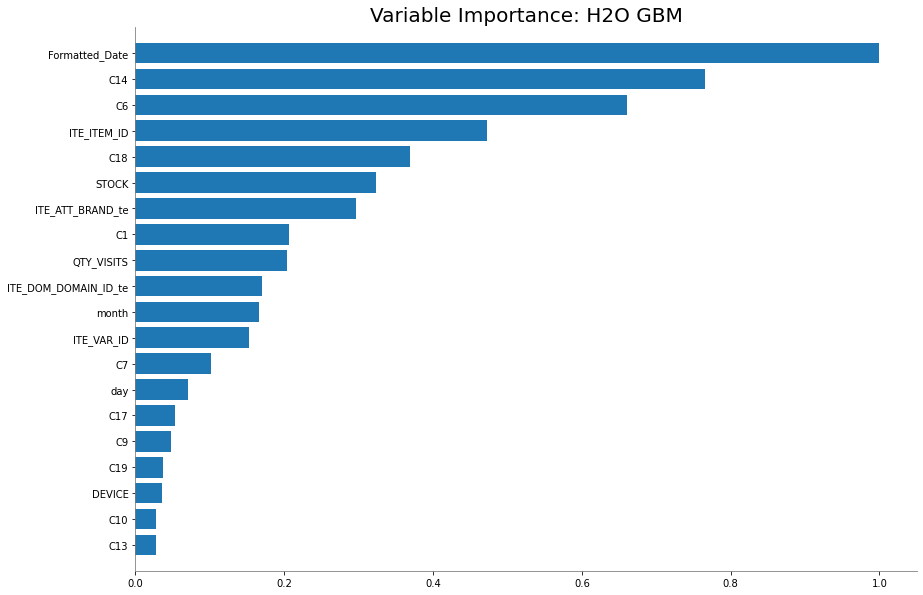

In [46]:
gbm_word_embeddings_fold_column.varimp_plot(num_of_features=20)

# Anomaly Score
También podemos calcular información interesante sobre los datos. *Por* ejemplo

    qué segmentos naturales se encuentran en los datos
    qué registros son extraños


In [47]:
train = ext_h2o_df[ext_h2o_df['Formatted_Date'] < datetime.datetime(2020, 5, 9, 0, 0, 0),:]
test = ext_h2o_df[ext_h2o_df['Formatted_Date'] >= datetime.datetime(2020, 5, 9, 0, 0, 0),:]
train.shape
test.shape
train

ITE_ITEM_ID,ITE_VAR_ID,VENTAS,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,android,2935,2,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Mobile-WEB,1233,0,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2019,11,11,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,ios,74,3,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2019,11,11,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055
1.64281e+09,9.07836e+10,34,2019-11-11 00:00:00,107,Std_Desktop,721,1,MLA-CELLPHONES,Samsung,316,16,Samsung cell phone M10 16GB 2GB RAM released,2019,11,11,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333


In [48]:
from h2o.estimators import H2OIsolationForestEstimator
x = train.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
isolation_forest = H2OIsolationForestEstimator(seed = 1234,
                                               model_id = "isolation_forest.hex"
                                              )
isolation_forest.train(training_frame = train, x = x)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [49]:
isolation_forest.predict(train)

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.22963,6.38
0.296296,6.2
0.22963,6.38
0.22963,6.38
0.244444,6.34
0.214815,6.42
0.192593,6.48
0.244444,6.34
0.2,6.46
0.155556,6.58


In [116]:
# Add Isolation Forest scores to train 
anomaly_scores_train = isolation_forest.predict(train)["predict"]
anomaly_scores_train.col_names = ["AnomalyScore"]
train = train.cbind(anomaly_scores_train)

# Add Isolation Forest scores to test 
anomaly_scores_test = isolation_forest.predict(test)["predict"]
anomaly_scores_test.col_names = ["AnomalyScore"]
test = test.cbind(anomaly_scores_test)

isolationforest prediction progress: |████████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [51]:
x = train.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
from h2o.estimators import H2OGradientBoostingEstimator
gbm_word_embeddings_AnomalyScore = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_word_embeddings_AnomalyScore.hex", 
                                                   ntrees = 500, 
                                                  #  stopping_rounds = 10, score_tree_interval = 5, # early stopping 
                                                   nfolds = 5, # 5-fold cross validation
                                                   balance_classes=False,
                                                  )
gbm_word_embeddings_AnomalyScore.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
print("rmse on - Baseline: " + str(round(gbm_baseline.rmse(xval = True), 4)))
print("rmse on - No Desc: " + str(round(gbm_no_title.rmse(xval = True), 4)))
print("rmse on - Word Embeddings: " + str(round(gbm_word_embeddings.rmse(xval = True), 4)))
print("rmse on - Word Embeddings + K fold column: " + str(round(gbm_word_embeddings_fold_column.rmse(xval = True), 4)))
print("rmse on - Word Embeddings + Anomaly Score: " + str(round(gbm_word_embeddings_AnomalyScore.rmse(xval = True), 4)))


rmse on - Baseline: 11.5954
rmse on - No Desc: 12.2915
rmse on - Word Embeddings: 11.3298
rmse on - Word Embeddings + K fold column: 12.137
rmse on - Word Embeddings + Anomaly Score: 19.0286


# Analicemos los resultados en Test

In [117]:
print("rmse on Test - Baseline: " + str(round(gbm_baseline.model_performance(test).rmse(), 4)))
print("rmse on Test - Baseline No Title: " + str(round(gbm_no_title.model_performance(test).rmse(), 4)))
print("rmse on Test - Word Embeddings: " + str(round(gbm_word_embeddings.model_performance(test).rmse(), 4)))
print("rmse on Test - Word Embeddings + K fold column: " + str(round(gbm_word_embeddings_fold_column.model_performance(test_te).rmse(), 4)))
print("rmse on Test - Word Embeddings + Anomaly Score: " + str(round(gbm_word_embeddings_AnomalyScore.model_performance(test).rmse(), 4)))

rmse on Test - Baseline: 78.1444
rmse on Test - Baseline No Title: 69.6197
rmse on Test - Word Embeddings: 66.685
rmse on Test - Word Embeddings + K fold column: 60.0883
rmse on Test - Word Embeddings + Anomaly Score: 67.376


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

/usr/local/lib/python3.7/dist-packages/h2o/job.py:72: UserWarning: Test/Validation dataset is missing column 'ITE_DOM_DOMAIN_ID_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:72: UserWarning: Test/Validation dataset is missing column 'ITE_ATT_BRAND_te': substituting in a column of NaN
  warnings.warn(w)


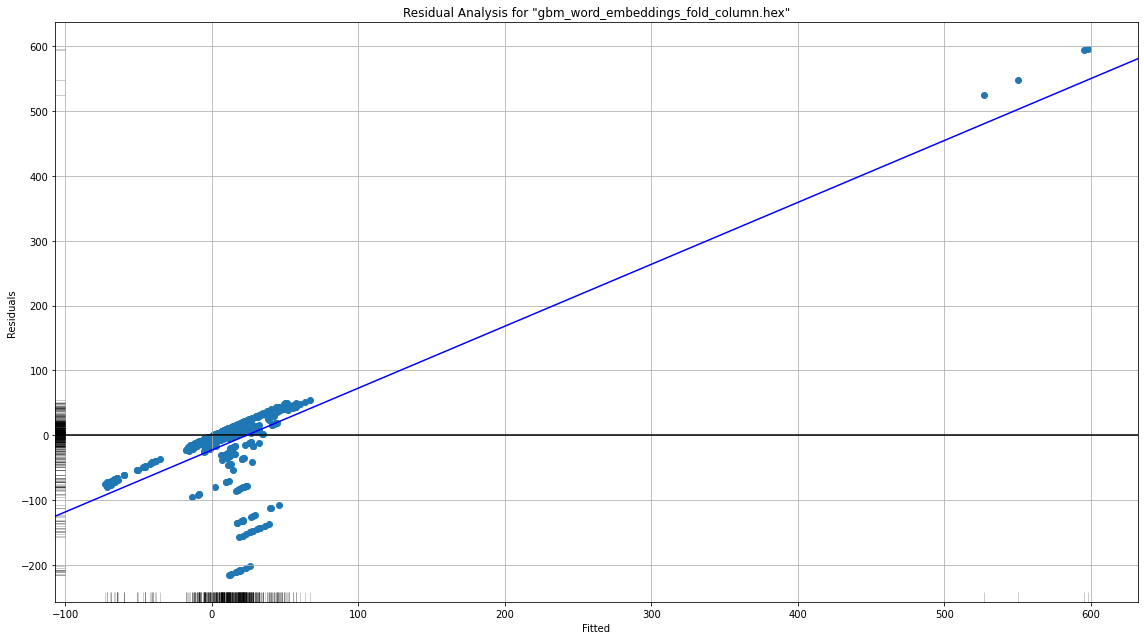

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

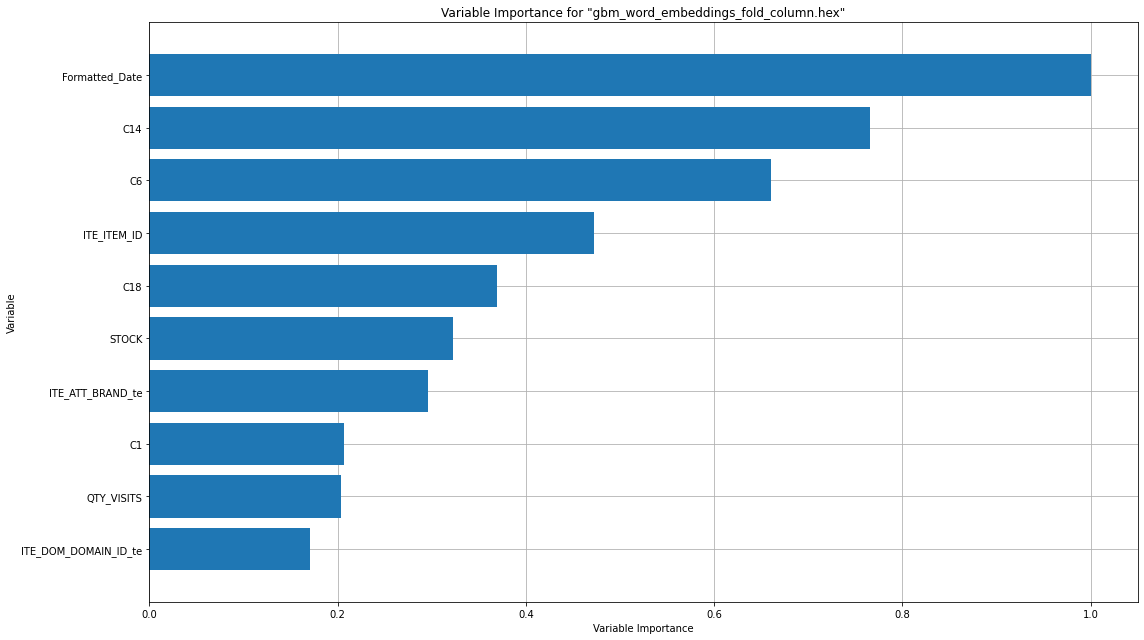

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

/usr/local/lib/python3.7/dist-packages/h2o/job.py:72: UserWarning: Test/Validation dataset is missing column 'ITE_DOM_DOMAIN_ID_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:72: UserWarning: Test/Validation dataset is missing column 'ITE_ATT_BRAND_te': substituting in a column of NaN
  warnings.warn(w)


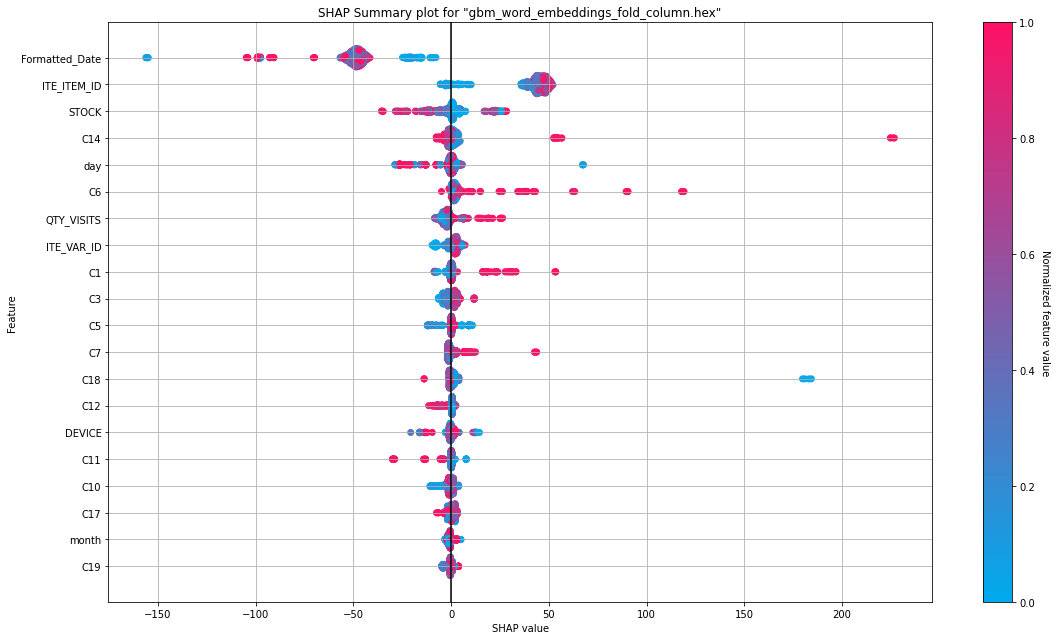

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

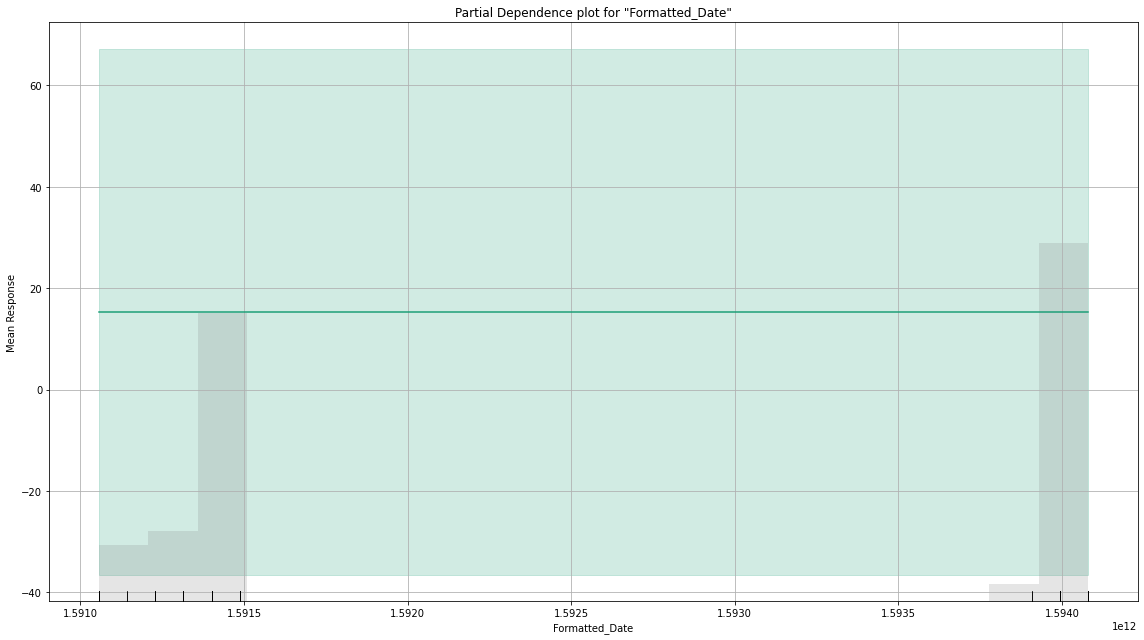

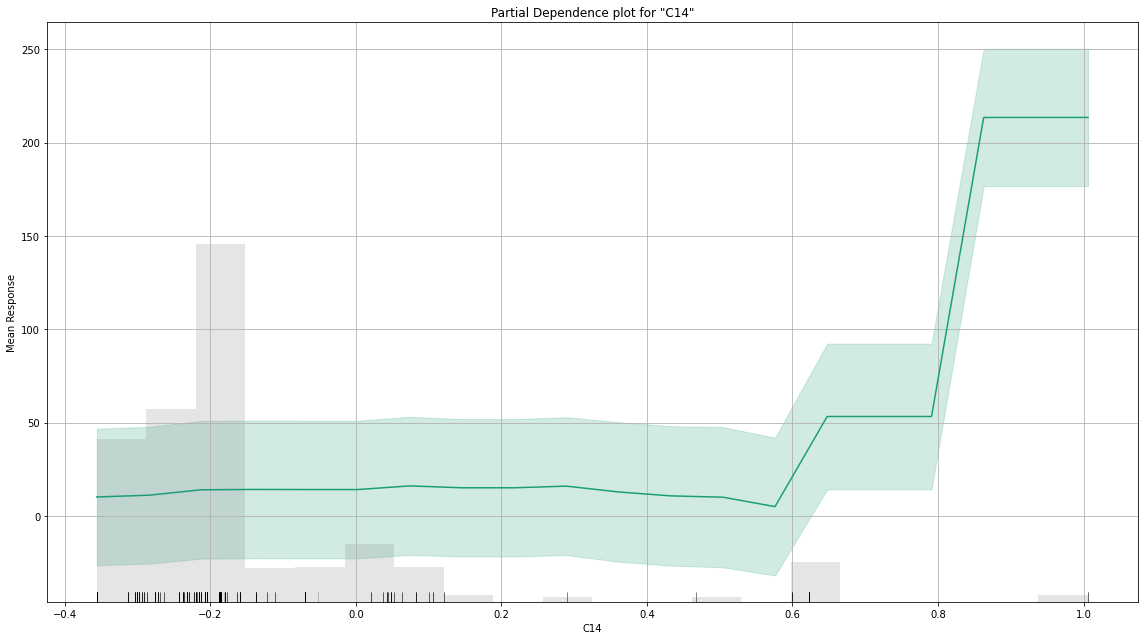

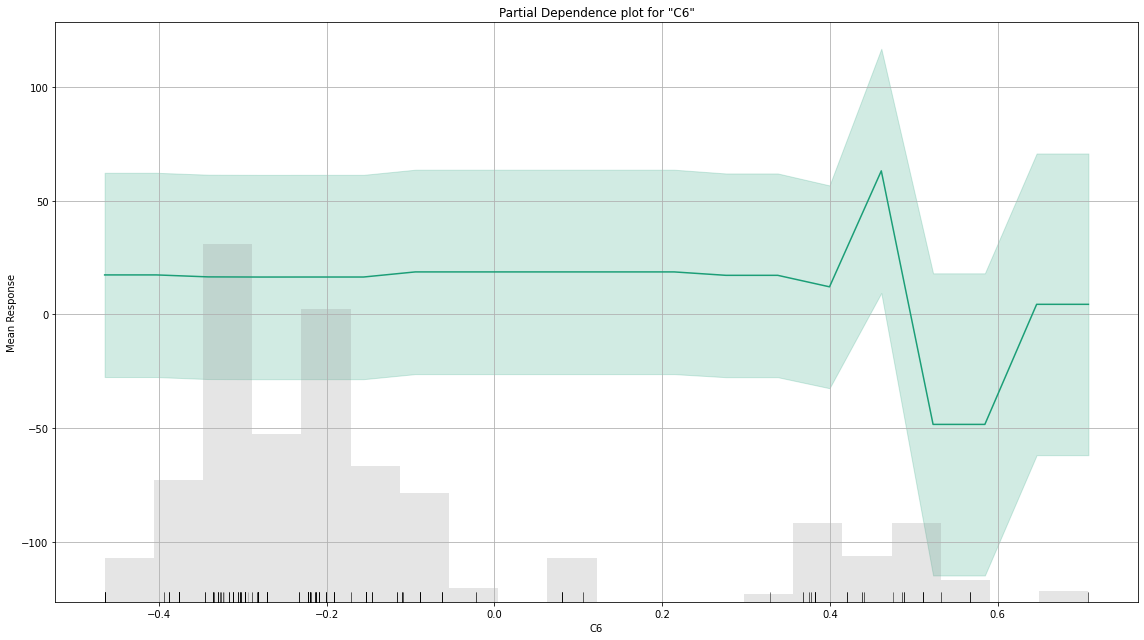

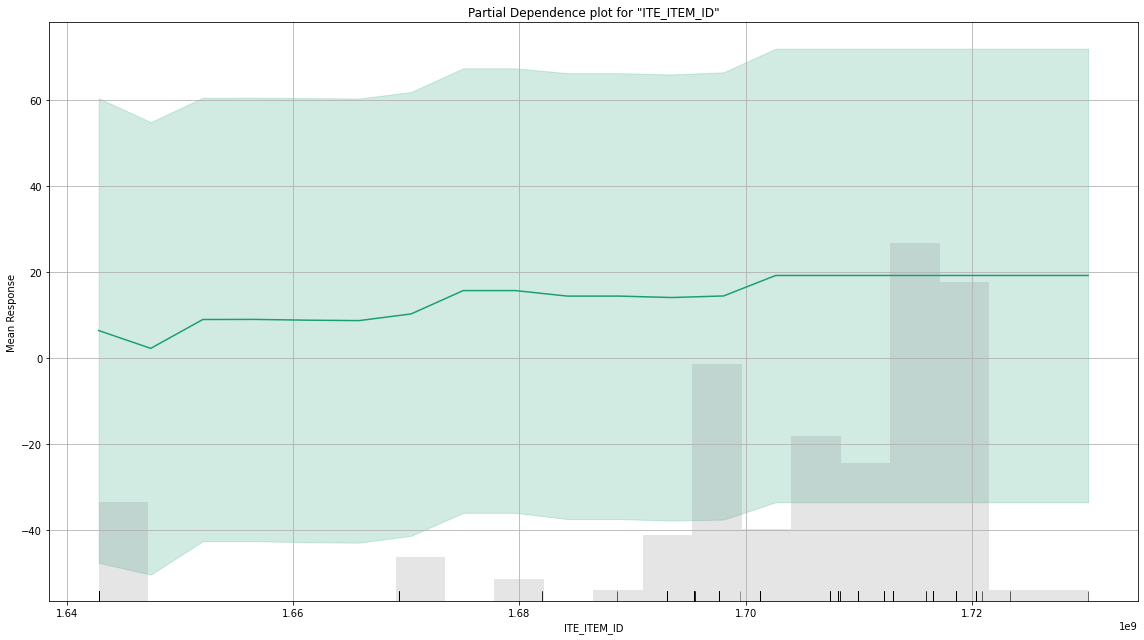

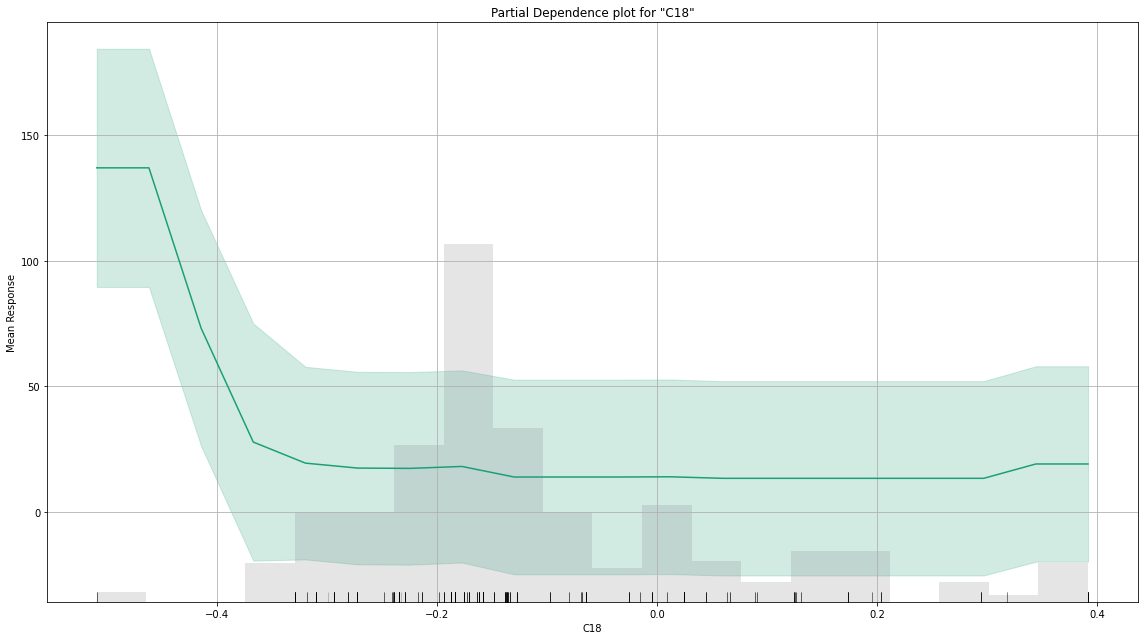

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

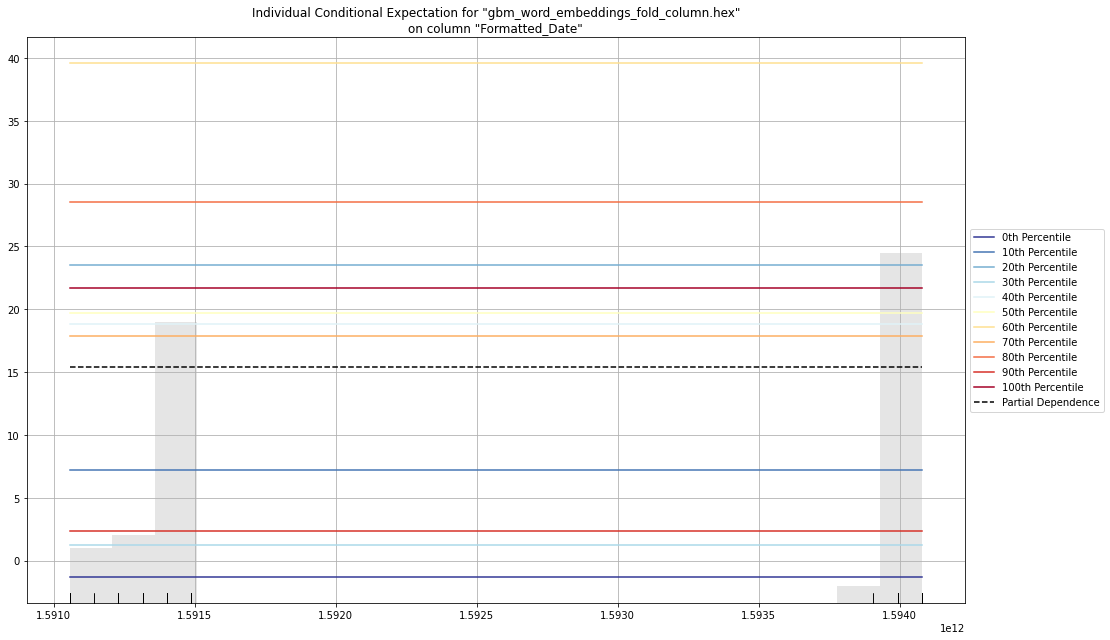

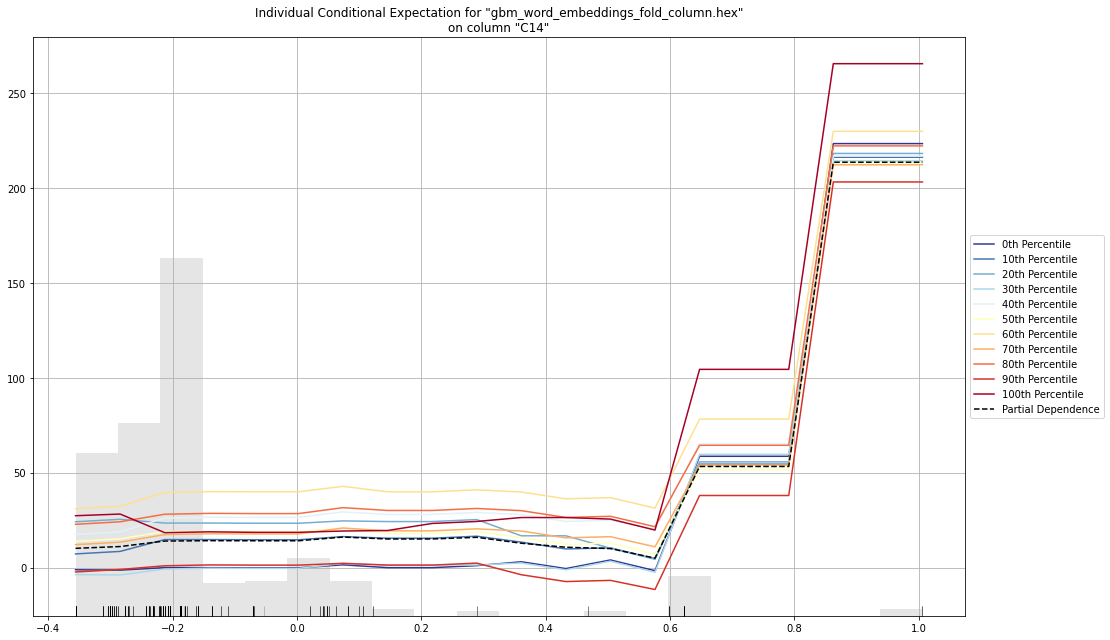

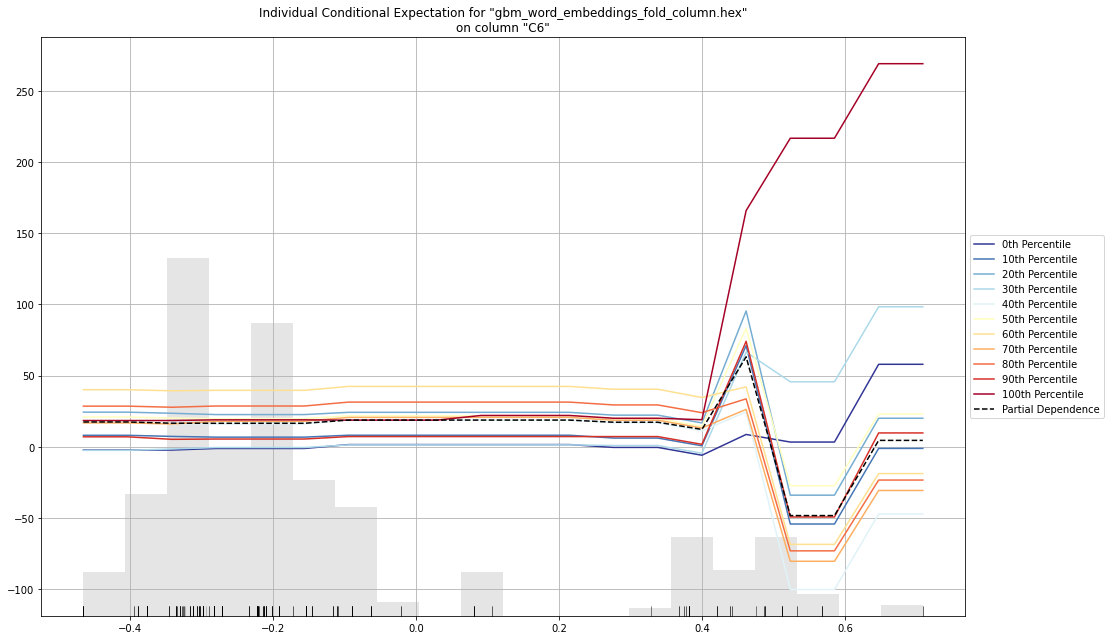

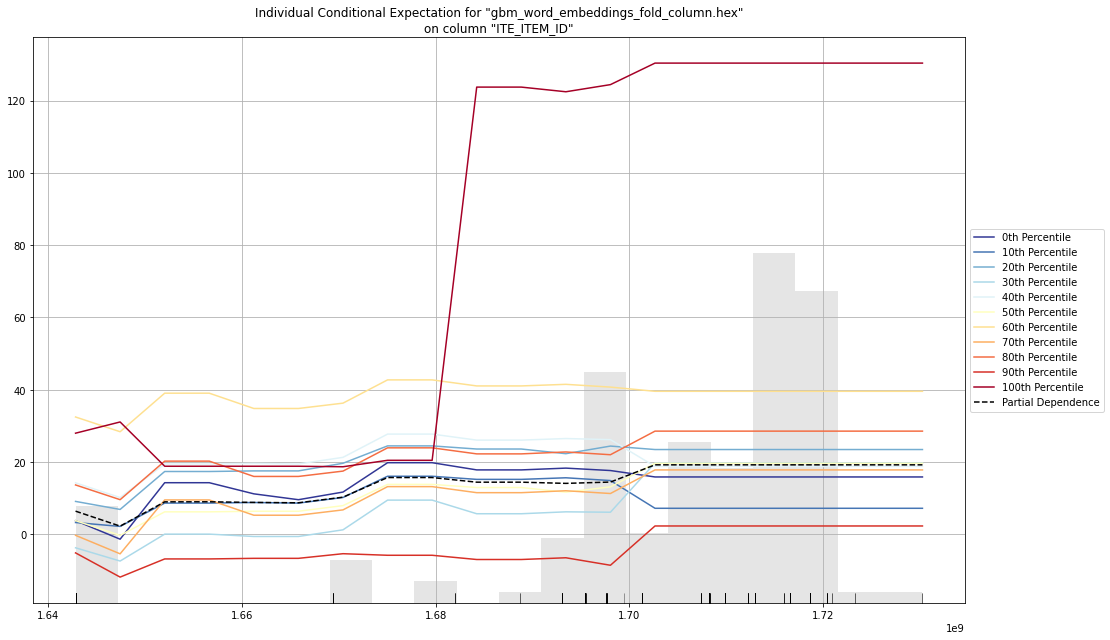

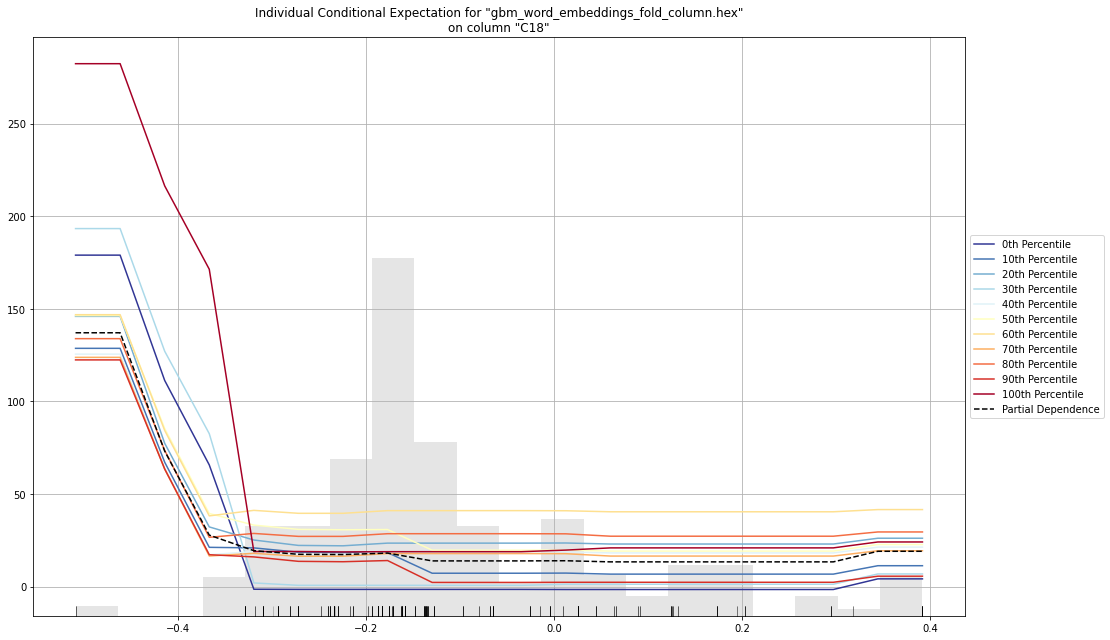

In [57]:
exa = gbm_word_embeddings_fold_column.explain(test)

In [114]:
test_te

ITE_ITEM_ID,ITE_VAR_ID,ITE_DOM_DOMAIN_ID_te,ITE_ATT_BRAND_te,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,Formatted_Date,STOCK,DEVICE,QTY_VISITS,DEVICE_cat,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En,year,month,day,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,VENTAS
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Std_Desktop,14,1,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Std_Desktop,14,1,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Std_Desktop,14,1,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,android,83,2,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,android,83,2,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,android,83,2,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Mobile-WEB,13,0,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Mobile-WEB,13,0,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB,2020,6,2,0.0508674,-0.0954882,-0.0680638,-0.199819,-0.0603968,-0.326363,-0.514721,-0.0413824,0.673109,0.0904647,-0.020373,0.0425416,0.132659,-0.269589,0.765245,-0.146277,-0.17787,-0.318083,0.221104,-0.0387525,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,Mobile-WEB,13,0,316,16,Samsung Galaxy M10 16 GB Blue Ocean 2 GB RAM,2020,6,2,0.128371,-0.063204,-0.0766595,-0.23746,-0.0200699,-0.3881,-0.4931,0.0380561,0.666622,0.188035,0.0758122,-0.0566228,0.228471,-0.237578,0.85164,-0.0757757,-0.196644,-0.186754,0.227932,0.162055,2
1.64281e+09,9.07836e+10,22.4932,25.753,MLA-CELLPHONES,Samsung,2020-06-02 00:00:00,0,ios,4,3,316,16,Samsung cell phone M10 16GB 2GB RAM released,2020,6,2,-0.147636,0.083475,-0.319184,0.160168,-0.023959,-0.171278,-0.0951497,-0.139179,0.141886,0.1312,-0.644968,-0.0393186,-0.382779,-0.0693201,0.299083,-0.178766,0.38373,0.0632358,-0.108893,-0.369333,2


# Resultados!
El dispositivo utilizado no presenta una influencia en la respuesta media de venta

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_word_embeddings_fold_column.hex on column 'DEVICE_cat'.


,device_cat,mean_response,stddev_response,std_error_mean_response
0,0.0,14.482203,39.710539,1.672115
1,1.0,14.482203,39.710539,1.672115
2,2.0,14.482203,39.710539,1.672115
3,3.0,14.426266,39.686593,1.671107


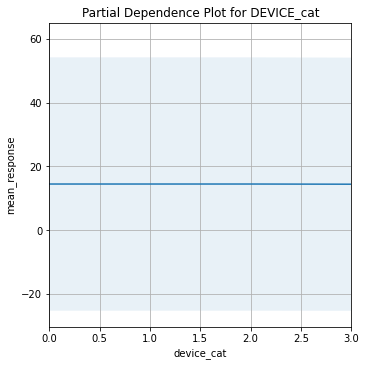

In [106]:
import numpy as np

def partial_dependence_plot_bins(columna="DEVICE_cat", row_index=0):
  quantiles = list(np.linspace(0,1,20))
  bins = test_te[columna].quantile(prob=quantiles).as_data_frame().iloc[:, 1].values
  gbm_word_embeddings_fold_column.partial_plot(test_te, cols=[columna], user_splits={columna: bins}, figsize=(5, 5));
  jobrole_pdp = gbm_word_embeddings_fold_column.partial_plot(test_te, cols = [columna], plot=False)
  print(jobrole_pdp[0])
  # gbm_word_embeddings_fold_column.partial_plot(test_te, cols = [columna], figsize=(5, 5), row_index=row_index);


partial_dependence_plot_bins()

En la cantidad de visitas se ven claramente dos momentos.
El primer momento presenta de subida clara de la respuesta media de ventA hasta las 1000 visitas y una pendiente menor para visitas mayores.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_word_embeddings_fold_column.hex on column 'QTY_VISITS'.


,qty_visits,mean_response,stddev_response,std_error_mean_response
0,0.000000,11.475899,38.552753,1.623364
1,262.052632,12.583813,39.467037,1.661862
2,524.105263,18.511001,44.278532,1.864463
3,786.157895,20.755378,44.771768,1.885232
4,1048.210526,41.047972,50.810568,2.139511
5,1310.263158,35.395210,48.562828,2.044864
6,1572.315789,39.602713,48.816961,2.055565
7,1834.368421,47.504194,48.913906,2.059647
8,2096.421053,47.914073,50.024155,2.106397
9,2358.473684,49.336736,49.946844,2.103142


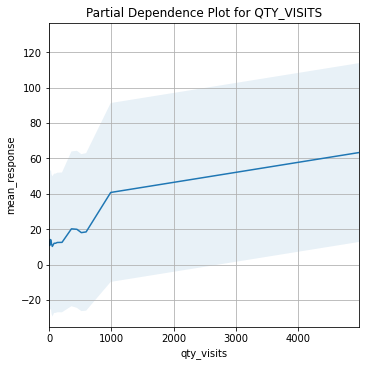

In [107]:
partial_dependence_plot_bins(columna="QTY_VISITS")

Valores de STOCK cercanos a los 200 items generan una alta respuesta media de venta

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_word_embeddings_fold_column.hex on column 'STOCK'.


,stock,mean_response,stddev_response,std_error_mean_response
0,0.000000,18.633591,38.475748,1.620121
1,97.157895,13.117259,35.670075,1.501981
2,194.315789,38.232036,37.215196,1.567042
3,291.473684,8.652124,37.118212,1.562959
4,388.631579,-5.169150,37.180174,1.565568
5,485.789474,-6.630751,37.414240,1.575424
6,582.947368,-2.896411,37.674190,1.586370
7,680.105263,26.278482,38.099295,1.604270
8,777.263158,-24.640361,38.682532,1.628828
9,874.421053,15.965982,38.096789,1.604164


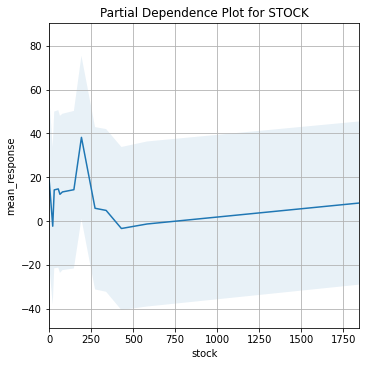

In [108]:
partial_dependence_plot_bins(columna="STOCK")

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_word_embeddings_fold_column.hex on column 'ITE_ITEM_ID'.


,ite_item_id,mean_response,stddev_response,std_error_mean_response
0,1.642812e+09,5.468837,42.933310,1.807818
1,1.647414e+09,1.339471,41.201767,1.734907
2,1.652016e+09,7.916181,39.342888,1.656634
3,1.656619e+09,7.933251,39.351914,1.657015
4,1.661221e+09,7.752935,39.381430,1.658257
5,1.665824e+09,7.654119,39.378270,1.658124
6,1.670426e+09,9.205472,39.371092,1.657822
7,1.675028e+09,14.609228,39.574973,1.666407
8,1.679631e+09,14.642345,39.537729,1.664839
9,1.684233e+09,13.397978,39.720072,1.672517


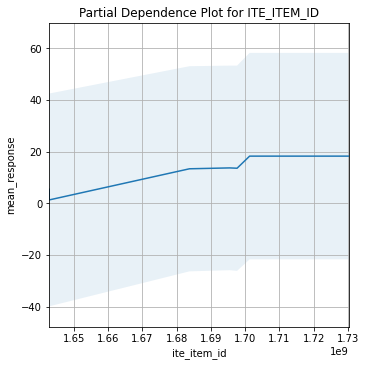

In [110]:
partial_dependence_plot_bins(columna="ITE_ITEM_ID")


El gráfico de dependencia parcial para la ITE_ITEM_ID muestra que hay un aumento significativo de la probabilidad de compra a lo largo del tiempo.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model gbm_word_embeddings_fold_column.hex on column 'C18'.


,c18,mean_response,stddev_response,std_error_mean_response
0,-0.508873,136.649438,36.691984,1.545011
1,-0.461478,136.649438,36.691984,1.545011
2,-0.414082,72.642484,36.325102,1.529563
3,-0.366686,27.561161,38.894245,1.637743
4,-0.319290,18.826092,29.214301,1.230144
5,-0.271895,16.823364,29.151476,1.227499
6,-0.224499,16.294012,29.255256,1.231868
7,-0.177103,17.194984,29.134252,1.226773
8,-0.129708,13.028895,30.033720,1.264648
9,-0.082312,13.028895,30.033720,1.264648


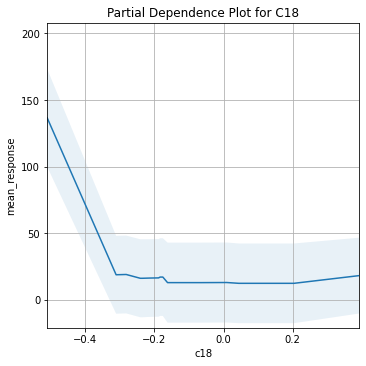

In [136]:
partial_dependence_plot_bins(columna="C18")

# Modelo Surrogado
Ahora podemos construir un modelo de árbol de decisión subrogado para explicar, a alto nivel, cómo predice nuestro modelo.

La idea que hay tras los modelos subrogados es utilizar un modelo más sencillo para explicar otro más complejo.

In [120]:
surrogate_dt_data = gbm_word_embeddings_fold_column.predict(train_te).cbind(train_te)
surrogate_dt_data.head()

x = train_te.columns
y = "VENTAS"
x.remove(y)
x.remove("ITE_ITEM_TITLE_En")
# x.remove("ITE_ITEM_ID")
# x.remove("ITE_VAR_ID")
x.remove("ITE_ATT_BRAND")
x.remove("ITE_DOM_DOMAIN_ID")
x.remove("ITE_ATT_BRAND_Cat")
x.remove("ITE_DOM_DOMAIN_ID_Cat")
from h2o.estimators.random_forest import H2ORandomForestEstimator

dt = H2ORandomForestEstimator(model_id="surrogate.hex",
                              ntrees=1, max_depth=3,
                              sample_rate=1,
                              categorical_encoding="one_hot_explicit",
                              mtries=27,
                              min_rows=20 # use min rows to prevent small leaf nodes and fitting noise
                             )
dt.train(y=y, training_frame=surrogate_dt_data, x=x)


gbm prediction progress: |████████████████████████████████████████████████| 100%


Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [127]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(model, tree_number):
    # Download MOJO
    mojo_path = model.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", str(tree_number), "-i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o decision_tree.png"], shell=False)
    result = subprocess.call(["ls","decision_tree.png"], shell = False)
    
    return Image(" decision_tree.png")

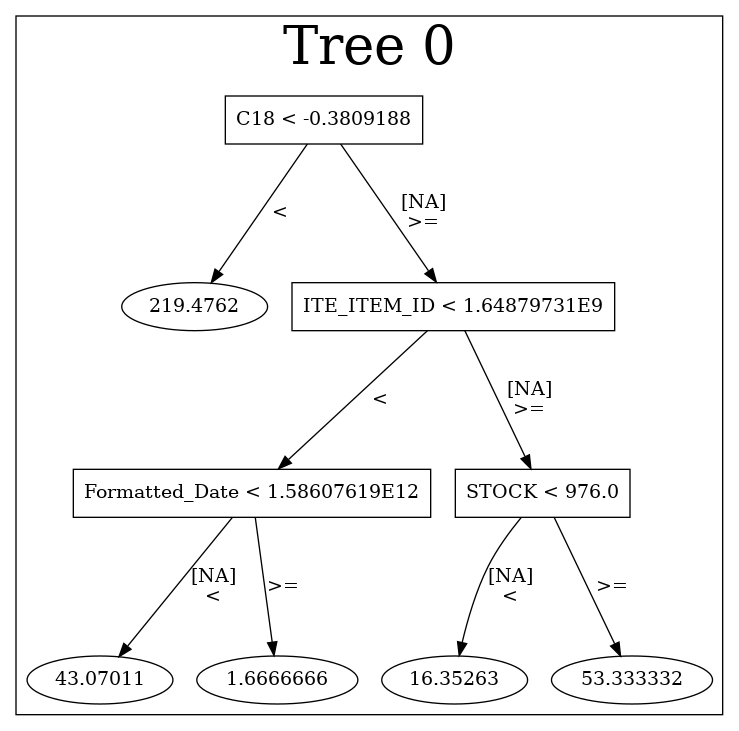

In [128]:
generateTreeImage(dt, 0)

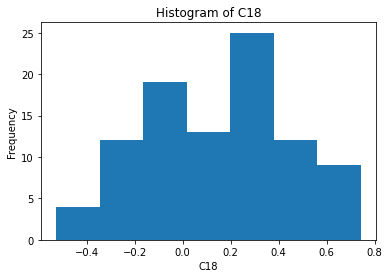

In [131]:
words=name
# Get Word Embeddings per Word
unique_words = words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]
word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]
word_embeddings["C18"].hist()

In [142]:
low_C18_words = word_embeddings[word_embeddings["C18"] < -0.389]
low_C18_words[["Word", "C18"]].head(50)


Word,C18
alcohol,-0.550193
black,-0.737867
blue,-0.55275
bottle,-0.594725
clear,-0.465011
coal,-0.481171
crush,-0.79855
dark,-0.398274
fine,-0.391742
gel,-0.499761


Mejores productos para vender son las botellas de alcohol en gel, los videos juegos (NINTENDO, PLAY), que tienen colores oscuros y la marca procleanex




In [143]:
low_C18_words = word_embeddings[word_embeddings["C18"] >= -0.389]
low_C18_words[["Word", "C18"]].head(50)

Word,C18
aura,-0.260635
aurora,0.014189
bass,0.313794
bluetooth,0.57105
buds,-0.0240347
cell,0.229078
cellular,-0.318083
ceramic,-0.373203
cloud,0.0190763
coral,-0.00163516


Productos con menos probabilidad de venta son motorola, philips, phone, moto, headphones, bass, bluetooth, buds, cell, cellular.

In [146]:
df.sort_values(by=['VENTAS'])

,DATE,SITIO_x,ITE_ITEM_ID,ITE_VAR_ID,NEGOCIO_ID,NEGOCIO,VENTAS,Formatted_Date,STOCK,SITIO_y,DEVICE,QTY_VISITS,DEVICE_cat,Unnamed: 0,SITIO,ITE_ITEM_TITLE,ITE_STATUS,ITE_DOM_DOMAIN_ID,ITE_ATT_BRAND,ITE_ATT_BRAND_Cat,ITE_DOM_DOMAIN_ID_Cat,ITE_ITEM_TITLE_En
937,12/11/2019,MLA,1642699308,90554654474,960899288,ELECTRONICS,1,2019-12-11,0.0,MLA,ios,1,3,2490,MLA,Celular Motorola Moto G6 Xt-1925 3gb 32gb Cuotas Sin Interes,paused,MLA-CELLPHONES,Motorola,203,16,Motorola Moto G6 XT-1925 3GB 32GB Fees without interest
1046,5/3/2020,MLA,1654754638,94011314006,960899288,ELECTRONICS,1,2020-05-03,0.0,MLA,android,1,2,31,MLA,Motorola Moto G6 Plus 64gb 4gb Ram Cuotas Sin Interes,paused,MLA-CELLPHONES,Motorola,203,16,Motorola Moto G6 Plus 64GB 4GB RAM Fees without interest
3892,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,Mobile-WEB,2,0,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
3893,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,android,23,2,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
3894,5/6/2020,MLA,1693043200,106536027816,960899288,ELECTRONICS,1,2020-05-06,29.0,MLA,ios,10,3,1314,MLA,Auriculares Philips Upbeat True Wireless Shb2505wt/00,paused,MLA-HEADPHONES,Philips,261,43,PHILIPS UPBEAT TRUE WIRELESS SHB2505WT / 00 headphones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,4/4/2020,MLA,1642811552,90783591526,960899288,ELECTRONICS,345,2020-04-04,0.0,MLA,ios,1137,3,769,MLA,Samsung Galaxy M10 - Negro Carbón - 16 Gb - 2 Gb,paused,MLA-CELLPHONES,Samsung,316,16,Samsung Galaxy M10 - Black Coal - 16 GB - 2 GB
3606,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,ios,287,3,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle
3605,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,Mobile-WEB,373,0,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle
3604,4/4/2020,MLA,1688656308,105053842740,960899288,ELECTRONICS,1040,2020-04-04,0.0,MLA,Std_Desktop,494,1,2711,MLA,Alcohol En Gel Procleanex 500 Ml Botella Pet,paused,MLA-ANTIBACTERIAL_GELS,PROCLEANEX,249,2,Alcohol in gel procleanex 500 ml pet bottle


# Referencias

https://d-salvaggio.medium.com/multilingual-universal-sentence-encoder-muse-f8c9cd44f171

